In [ ]:
from pathlib import Path
from netCDF4 import Dataset


# Open the NetCDF file
file_path = Path('/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/time_series/USGS-01015000.nc')
dataset = Dataset(file_path, 'r')

# Print all available variables
print("Available variables in the NetCDF file:")
for var_name in dataset.variables.keys():
    print(var_name)

# # Close the dataset
# dataset.close()

In [1]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except: #Throws if already set
    pass

# Disable CUDA graphs
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_enable_command_buffer='

In [2]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
import pickle
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

from train import load_last_state
from data import TAPDataset, TAPDataLoader
from evaluate import *

In [124]:
run_dir = Path("../runs/hybrid_multitarget_064_030/1_head_4_layer_all_sat_all_target_20240618_211259")
cfg, model, trainer_state, opt_state, _ = load_last_state(run_dir)
cfg['quiet'] = False

fig_dir = run_dir / "figures"
fig_dir.mkdir(exist_ok=True)

ts_dir = fig_dir / "timeseries"
ts_dir.mkdir(exist_ok=True)

# Bandaid for old configs. 
if not isinstance(cfg['features']['target'],list):
    cfg['features']['target'] = [cfg['features']['target']]
    
dataset = TAPDataset(cfg)


Loading model state from ../runs/hybrid_multitarget_064_030/1_head_4_layer_all_sat_all_target_20240618_211259/epoch023
Dropping static attributes with 0 variance: ['glc_pc_s03', 'glc_pc_s05', 'glc_pc_s07', 'glc_pc_s08', 'glc_pc_s17', 'glc_pc_s19', 'pnv_pc_s03', 'wet_pc_s05', 'wet_pc_s06', 'wet_pc_s07']
Using cached basin dataset file.


In [125]:
cfg['data_subset'] = 'test'
cfg['num_workers'] = 1
cfg['basin_subset'] = None
cfg['batch_size'] = 1048
dataloader = TAPDataLoader(cfg, dataset)

results = predict(model, dataloader, seed=0, denormalize=True, return_dt=True)
bulk_metrics = get_all_metrics(results, False)
basin_metrics = get_basin_metrics(results, True)

with open(run_dir / f"{cfg['data_subset']}_data.pkl", 'wb') as f:
    pickle.dump((results, bulk_metrics, basin_metrics), f)

Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 gpu(s)


  0%|          | 0/949 [00:58<?, ?it/s]

2024-06-19 15:30:39.850152: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Basin Metrics
SSC
num_obs: 6.0000
nBias: 0.1697
RE: 0.7256
rRMSE: 138.3642
KGE: 0.1933
NSE: -1.1428
Agreement: 0.3435

TURBIDITY
num_obs: 0.0000
nBias: 0.1747
RE: 0.7733
rRMSE: 132.2850
KGE: 0.1490
NSE: -0.7023
Agreement: 0.3459

FLUX
num_obs: 0.0000
nBias: 0.1832
RE: 1.0928
rRMSE: 205.7044
KGE: 0.1964
NSE: -0.3926
Agreement: 0.4526

USGS_Q
num_obs: 2188.0000
nBias: 0.0645
RE: 0.3394
rRMSE: 71.9109
KGE: 0.6425
NSE: 0.3539
Agreement: 0.7314




In [ ]:
with open(run_dir / "test_data.pkl", 'rb') as f:
    results, bulk_metrics, basin_metrics = pickle.load(f)

In [186]:
model

Hybrid(
  ealstm_d=EALSTM(
    hidden_size=64,
    cell=EALSTMCell(
      weight_ih=f32[192,37],
      weight_hh=f32[192,64],
      bias=f32[192],
      input_linear=Linear(
        weight=f32[64,226],
        bias=f32[64],
        in_features=226,
        out_features=64,
        use_bias=True
      )
    ),
    dropout=Dropout(p=0.1, inference=False),
    dense=None
  ),
  tealstm_i=TEALSTM(
    hidden_size=64,
    cell=TEALSTMCell(
      weight_ih=f32[192,16],
      weight_hh=f32[192,64],
      bias=f32[192],
      input_linear=Linear(
        weight=f32[64,226],
        bias=f32[64],
        in_features=226,
        out_features=64,
        use_bias=True
      ),
      weight_decomp=f32[64,64],
      bias_decomp=f32[64]
    ),
    dropout=Dropout(p=0.1, inference=False),
    dense=None
  ),
  static_embedder=StaticEmbedder(
    linear=Linear(
      weight=f32[900,226],
      bias=f32[900],
      in_features=226,
      out_features=900,
      use_bias=True
    ),
    layernorm=Layer

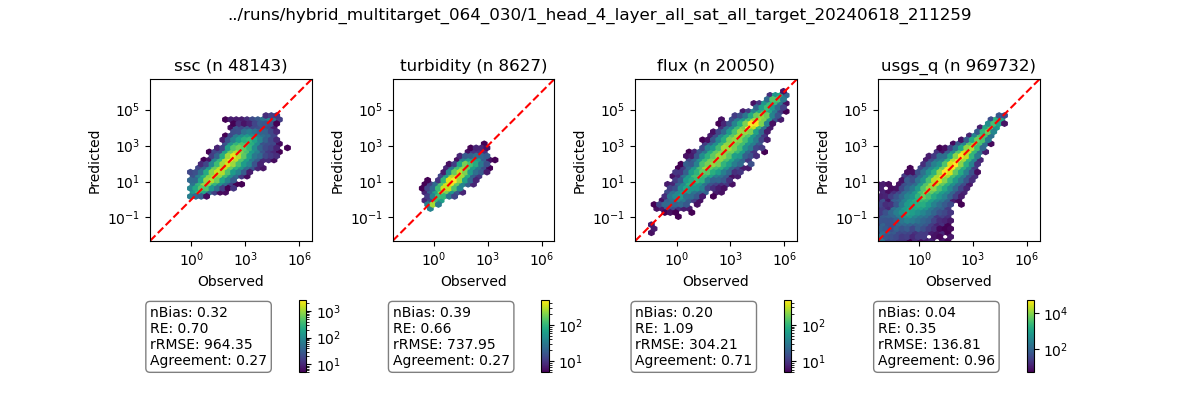

In [126]:
reload(evaluate)
from evaluate import mosaic_scatter

plt.close('all')
fig = mosaic_scatter(cfg, results, bulk_metrics, str(run_dir))

plt.show()
fig.savefig(fig_dir / f"epoch{trainer_state['epoch']:03d}_{cfg['data_subset']}_density_scatter.png",  dpi=300)


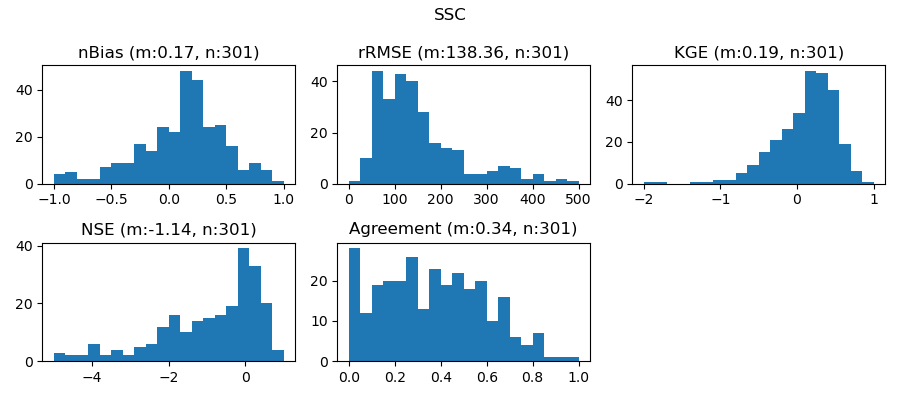

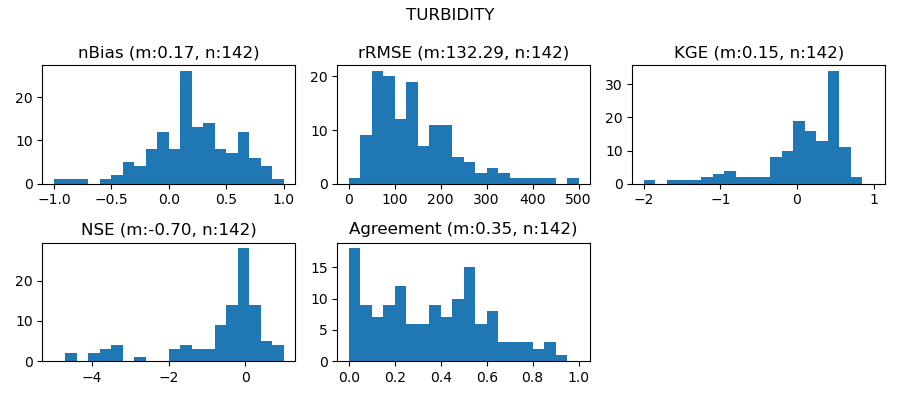

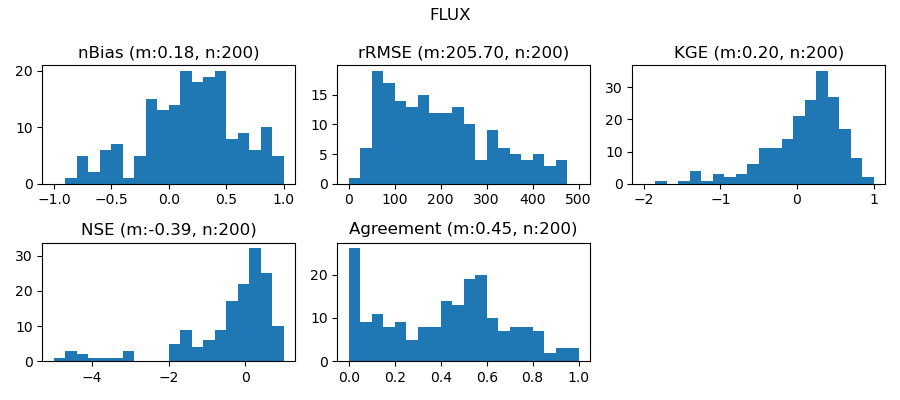

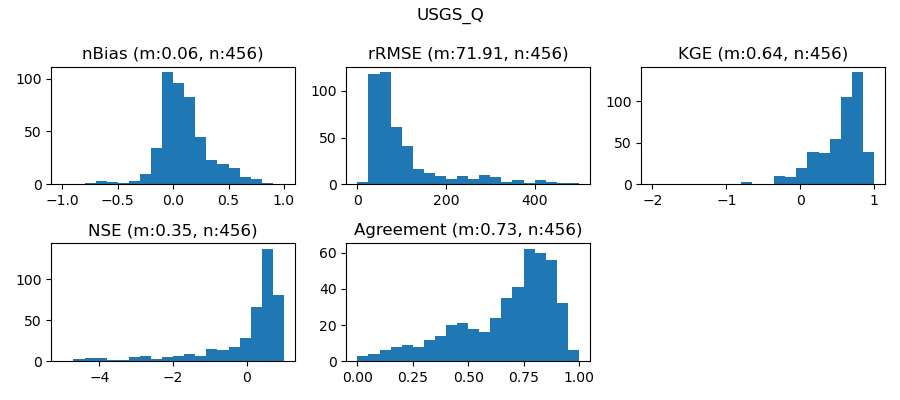

In [127]:
reload(evaluate)
from evaluate import *

metric_args = {
    'nBias':{'range':[-1,1]},
    'rRMSE':{'range':[0,500]},
    'KGE':{'range':[-2,1]},
    'NSE':{'range':[-5,1]},
    'Agreement':{'range':[0,1]}}

plt.close('all')

figs = basin_metric_histograms(basin_metrics, metric_args)

for target, fig in figs.items():
    # fig.show()
    fig.savefig(fig_dir / f"epoch{trainer_state['epoch']:03d}_{cfg['data_subset']}_{target}_metrics_hist.png",  dpi=300)
    

In [128]:
import matplotlib.gridspec as gridspec

def timeseries_plot(results, feature):
    pred = results['pred'][feature]
    obs = results['obs'][feature]
    joint = results[[('obs',feature),('pred',feature)]]
    joint = joint.dropna()
    
    if len(joint) < 2:
        return
           
    # Create a figure
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 2])
    axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])]
    
    min_val = joint.min().min()
    max_val = joint.max().max()

    axes[0].loglog(obs, pred, linestyle='None',marker='.', alpha=0.2)
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--')

    # Setting axes to be square and equal range
    axes[0].axis('square')
    axes[0].set_xlabel(f"Observed {feature}")
    axes[0].set_ylabel(f"Predicted {feature}")

    axes[0].set_title(f"Basin: {basin}")


    axes[1].plot(pred)
    axes[1].plot(obs, linestyle='None',marker='.',alpha=0.5)
    axes[1].set_title(f"{feature}")
    # axes[1].set_ylim([0,40000])

    textstr = '\n'.join([f"{key}: {basin_metrics.loc[basin][feature][key]:0.2f}" for key in ['rRMSE','KGE','NSE','Agreement']])
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axes[1].text(0.98, 0.97, textstr, transform=axes[1].transAxes, fontsize=10,
            va='top', ha='right', bbox=props)

    fig.suptitle(str(run_dir))
    fig.tight_layout()
    fig.autofmt_xdate()
    
    return fig

Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 gpu(s)


  0%|          | 0/3 [00:00<?, ?it/s]

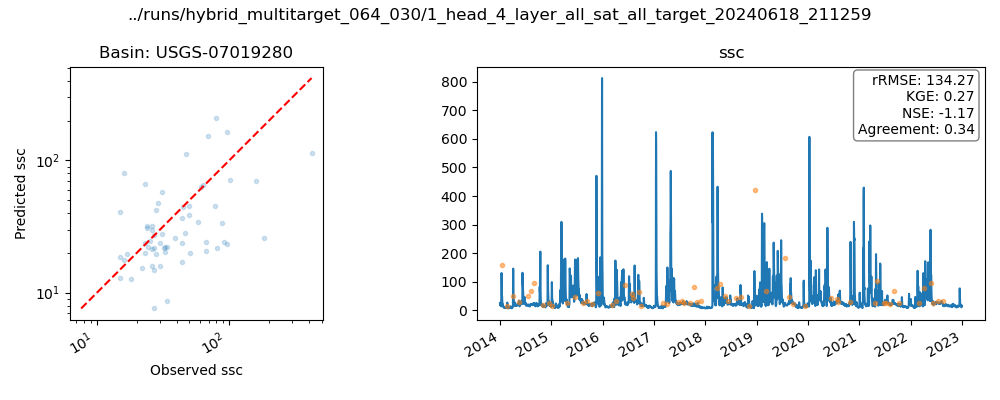

In [136]:
import evaluate
reload(evaluate)
from evaluate import predict, get_all_metrics

basin = np.random.choice(dataset.basins).tolist()
# basin = 'USGS-09367540'
# basin = 'USGS-06109500' #no flux but nice seasonality
# basin = 'USGS-08332010' #Nice flux temporal distribution and seasonality

cfg['data_subset'] = 'predict'
cfg['basin_subset'] =  basin
cfg['num_workers'] = 0 # Faster for small runs
dataloader = TAPDataLoader(cfg, dataset)

results = predict(model, dataloader, seed=0, denormalize=True, return_dt=True)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0

results = results.reset_index()
results = results.sort_values(by='date')
results = results.drop('basin', axis=1, level=0)
results.set_index('date', inplace=True)

plt.close('all')
features = results.columns.get_level_values('Feature').unique()

figs = []
for feature in features:
    fig = timeseries_plot(results, feature)
    if fig is None:
        continue
    # fig.savefig(ts_dir / f"epoch{trainer_state['epoch']:03d}_{cfg['data_subset']}_{basin}_{feature}_timeseries.png",  dpi=300)
    figs.append(fig)
if len(figs)==0:
    print("No data in basin and period")

In [137]:
for basin, date, batch in dataloader:
    break
batch['x_s']

Array([[-0.40815124, -0.3014212 , -0.42311767, ..., -0.17691213,
        -0.25849414,  0.6283132 ],
       [-0.40815124, -0.3014212 , -0.42311767, ..., -0.17691213,
        -0.25849414,  0.6283132 ],
       [-0.40815124, -0.3014212 , -0.42311767, ..., -0.17691213,
        -0.25849414,  0.6283132 ],
       ...,
       [-0.40815124, -0.3014212 , -0.42311767, ..., -0.17691213,
        -0.25849414,  0.6283132 ],
       [-0.40815124, -0.3014212 , -0.42311767, ..., -0.17691213,
        -0.25849414,  0.6283132 ],
       [-0.40815124, -0.3014212 , -0.42311767, ..., -0.17691213,
        -0.25849414,  0.6283132 ]], dtype=float32)

In [138]:
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, batch['x_s'].shape[0])

embedded = jax.vmap(model.static_embedder)(batch['x_s'], keys)

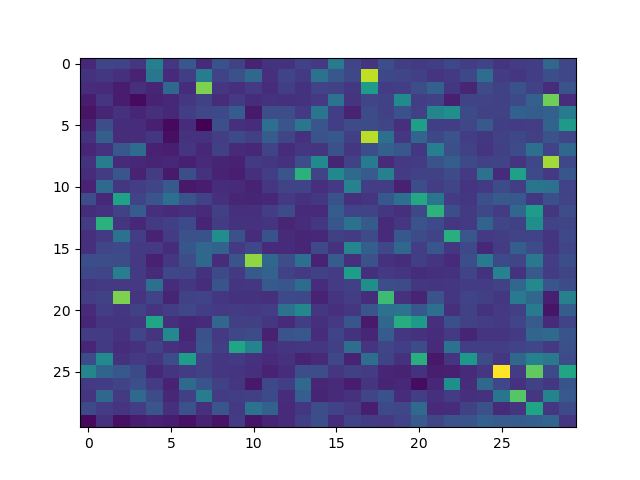

In [139]:
plt.close('all')
plt.imshow(embedded[0,...],aspect='auto')

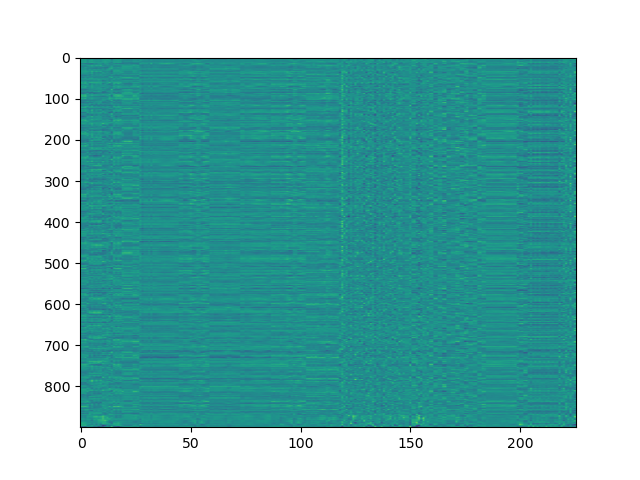

In [140]:
plt.close('all')
plt.imshow(model.static_embedder.linear.weight,aspect='auto')

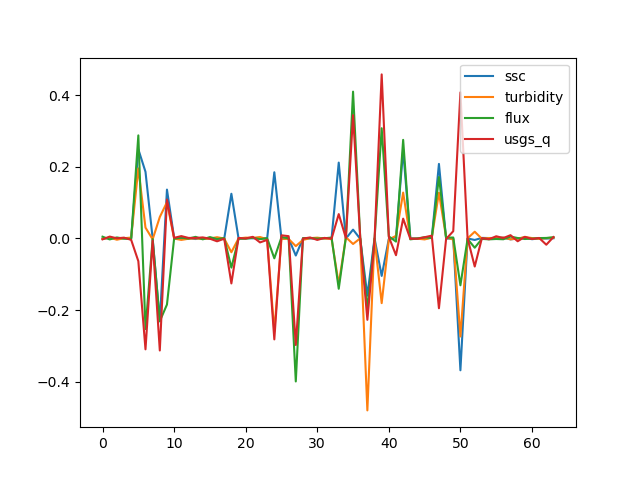

In [145]:
plt.close('all')
plt.plot(model.head.weight.T, label=cfg['features']['target'])
plt.legend()


['ssc', 'turbidity', 'flux', 'usgs_q']

In [ ]:
from train import Trainer, make_step

cfg['data_subset'] = 'test'
cfg['num_workers'] = 2
cfg['basin_subset'] = None
cfg['log'] = False
cfg['quiet'] = False
dataloader = TAPDataLoader(cfg, dataset)
trainer = Trainer(cfg, dataloader)

step_kwargs = cfg['step_kwargs']
step_kwargs['max_grad_norm'] = None

for basin, date, batch in dataloader:
    break

key = jax.random.PRNGKey(0)
batch_keys = jax.random.split(key, len(basin))

loss, grads, model, opt_state = make_step(
    model, 
    batch,
    batch_keys,
    opt_state, 
    trainer.optim, 
    trainer.filter_spec, 
    **step_kwargs
    )

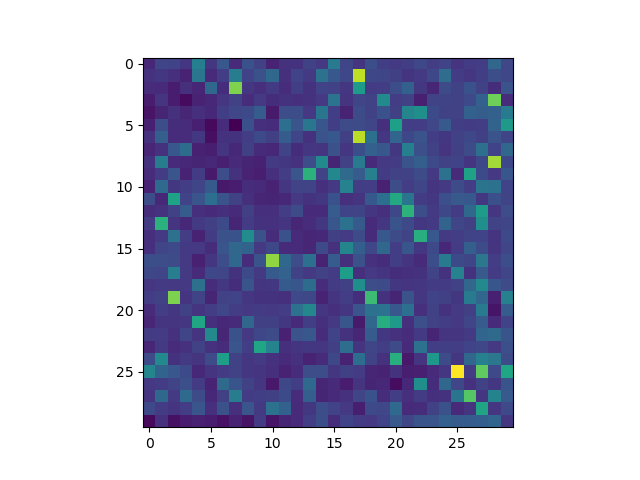

In [146]:
key = jax.random.PRNGKey(0)
keys = keys = jax.random.split(key, num=batch['x_s'].shape[0])
embedded = jax.vmap(model.static_embedder)(batch['x_s'],keys)

plt.close('all')
plt.imshow(embedded[0,...])

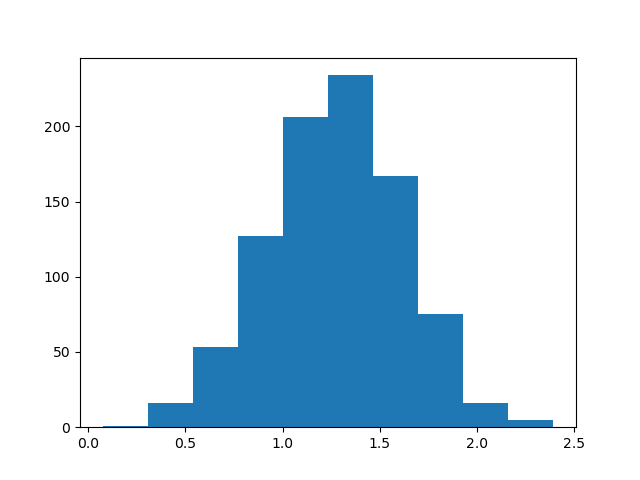

In [147]:
plt.close('all')
plt.hist(model.static_embedder.layernorm.weight)
plt.show()

In [ ]:
model

In [155]:
model.decoder.pooler

Linear(
  weight=f32[64,64],
  bias=f32[64],
  in_features=64,
  out_features=64,
  use_bias=True
)

In [159]:
model.static_embedder.linear.weight.shape

(900, 226)

dict_keys(['dis_m3_pyr', 'dis_m3_pmn', 'dis_m3_pmx', 'run_mm_syr', 'inu_pc_smn', 'inu_pc_umn', 'inu_pc_smx', 'inu_pc_umx', 'inu_pc_slt', 'inu_pc_ult', 'lka_pc_sse', 'lka_pc_use', 'lkv_mc_usu', 'rev_mc_usu', 'dor_pc_pva', 'ria_ha_ssu', 'ria_ha_usu', 'riv_tc_ssu', 'riv_tc_usu', 'gwt_cm_sav', 'ele_mt_sav', 'ele_mt_uav', 'ele_mt_smn', 'ele_mt_smx', 'slp_dg_sav', 'slp_dg_uav', 'sgr_dk_sav', 'clz_cl_smj', 'cls_cl_smj', 'tmp_dc_syr', 'tmp_dc_uyr', 'tmp_dc_smn', 'tmp_dc_smx', 'tmp_dc_s01', 'tmp_dc_s02', 'tmp_dc_s03', 'tmp_dc_s04', 'tmp_dc_s05', 'tmp_dc_s06', 'tmp_dc_s07', 'tmp_dc_s08', 'tmp_dc_s09', 'tmp_dc_s10', 'tmp_dc_s11', 'tmp_dc_s12', 'pre_mm_syr', 'pre_mm_uyr', 'pre_mm_s01', 'pre_mm_s02', 'pre_mm_s03', 'pre_mm_s04', 'pre_mm_s05', 'pre_mm_s06', 'pre_mm_s07', 'pre_mm_s08', 'pre_mm_s09', 'pre_mm_s10', 'pre_mm_s11', 'pre_mm_s12', 'pet_mm_syr', 'pet_mm_uyr', 'pet_mm_s01', 'pet_mm_s02', 'pet_mm_s03', 'pet_mm_s04', 'pet_mm_s05', 'pet_mm_s06', 'pet_mm_s07', 'pet_mm_s08', 'pet_mm_s09', 'pet_mm_s

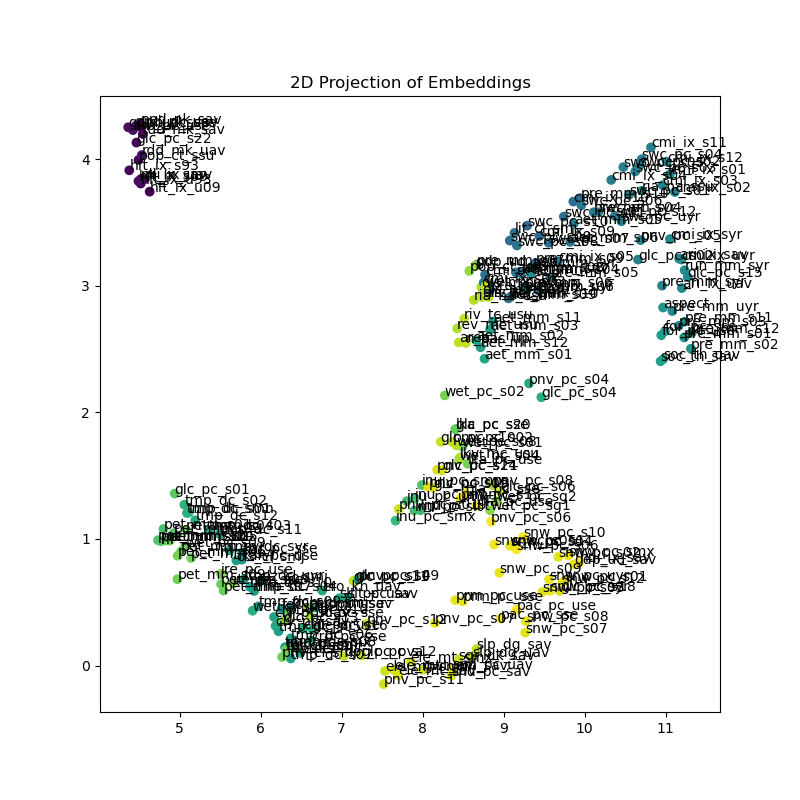

In [185]:
import umap

# mat_plot = embedded[0,...]
# mat_plot = model.tealstm_i.cell.weight_ih
mat_plot = model.static_embedder.linear.weight.T

# mat_plot = model.decoder.layers[0].attention_block.attention.output_proj.weight
# mat_plot = model.static_embedder.layernorm.weight

reducer = umap.UMAP(n_neighbors=16, n_components=3, metric='euclidean')
embedding_3d = reducer.fit_transform(mat_plot)

# Plot using matplotlib
plt.close('all')
figs, axes = plt.subplots(figsize=(8,8))

axes.scatter(embedding_3d[:, 0], embedding_3d[:, 1], c=embedding_3d[:,2])
axes.set_title('2D Projection of Embeddings')

for xyz, label in zip(embedding_3d, dataset.attributes_scale.keys()):
    axes.text(xyz[0], xyz[1], label)

plt.show()

In [ ]:
static_sums = np.sum(np.abs(static_embeddings),axis=0)
sorted_ids = np.argsort(-static_sums)

static_features = list(dataset.attributes_scale.keys())
for i in range(25):
    idx = sorted_ids[i]
    print(f"{static_features[idx]}: {static_sums[idx]}")

In [ ]:
plt.figure()
plt.hist(static_sums)

In [ ]:
plt.close('all')
plt.imshow(static_embeddings, aspect='auto')
plt.show()

In [ ]:
model.decoder.layers[0].attention_block.attention

In [ ]:
plt.close('all')

fig, ax = plt.subplots(figsize=(6,6))

x = results['obs']
y = results['pred']
z = []

dt_max = 10
for dt in range(dt_max+1):
    if dt < dt_max:
        mask = np.abs(results['dt']) == dt
    else:
        mask = np.abs(results['dt']) >= dt
    metrics = get_all_metrics(x[mask], y[mask])
    z.append(metrics['lNSE'])

ax.plot(z)

xticks = range(0,dt_max+1,2)
xtick_labels = ax.get_xticklabels()
new_labels = ["≥" + str(int(tick)) if tick == dt_max else str(int(tick)) for tick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(new_labels)

plt.show()